<a href="https://colab.research.google.com/github/EuclidesDoRosario/ML-Lab-1/blob/main/ML_LAB_001_hands_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Configuração do kaggle
NB: Se ainda não tem uma conta kaggle, por favor siga o seguinte vídeo: https://www.youtube.com/watch?v=rO8mkmzVmRI

É importante que tenha uma conta kaggle para continuar com esse lab.

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/KAGGLE_AUTH/kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

##Carregar o dataset do Kaggle


In [ ]:
! kaggle datasets download taeefnajib/used-car-price-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/109k [00:00<?, ?B/s]
100% 109k/109k [00:00<00:00, 37.4MB/s]


In [ ]:
!unzip /content/used-car-price-prediction-dataset.zip

Archive:  /content/used-car-price-prediction-dataset.zip
  inflating: used_cars.csv           


#Importar os módulos

In [ ]:
#Esses módulos podem ser substituídos ou também pode adicionar novos módulos.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

#Ler os dados do nosso dataset

In [ ]:
df = pd.read_csv('/content/used_cars.csv')

#Sobre os dados:
O Conjunto de Dados de Previsão de Preços de Carros Usados é uma coleção abrangente de informações automotivas extraídas do popular site de mercado automotivo, https://www.cars.com. Este conjunto de dados compreende 4.009 pontos de dados, cada um representando uma lista única de veículos, e inclui nove características distintas que fornecem insights valiosos sobre o mundo dos automóveis.

    Brand & Model: Identifica a marca ou o nome da empresa juntamente com o modelo específico de cada veículo.
    Model Year: Descubra o ano de fabricação dos veículos, crucial para avaliar a depreciação e os avanços tecnológicos.
    Mileage: Obtenha a quilometragem de cada veículo, um indicador chave de desgaste e possíveis necessidades de manutenção.
    Fuel Type: Saiba sobre o tipo de combustível utilizado pelos veículos, seja gasolina, diesel, elétrico ou híbrido.
    Engine Type: Compreenda as especificações do motor, lançando luz sobre o desempenho e a eficiência.
    Transmission: Determine o tipo de transmissão, seja automática, manual ou outra variante.
    Exterior & Interior Colors: Explore os aspectos estéticos dos veículos, incluindo opções de cores externas e internas.
    Accident History: Descubra se um veículo tem um histórico anterior de acidentes ou danos, crucial para uma tomada de decisão informada.
    Clean Title: Avalie a disponibilidade de um título limpo, que pode impactar o valor de revenda e o status legal do veículo.
    Price: Acesse os preços listados para cada veículo, ajudando na comparação de preços e no planejamento do orçamento.

Este conjunto de dados é um recurso valioso para entusiastas automotivos, compradores e pesquisadores interessados em analisar tendências, tomar decisões de compra informadas ou realizar estudos relacionados à indústria automotiva e às preferências dos consumidores. Seja você um analista de dados, comprador de carros ou pesquisador, este conjunto de dados oferece uma riqueza de informações para explorar e analisar.

#Data Check

In [ ]:
#Vamos visualizar alguns dados do dataset
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [ ]:
#Verificar se há dados nulos (dados em falta)
df.isnull().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

#Numa vista rápida notamos alguns probleminhas com os dados:
1. A quilometragem (`milage`) apresenta um padrão não numérico, porém a natureza é numérica.
2. `fuel_type`,`accident`,`clean_title` contêm valores nulos.
3. O preço (`price`) tem um padrão não numérico, por exemplo $100,00
4. O motor (`engine`) possuir


In [ ]:
#função utilitária
def formatar_para_numero(price):
    # Encontra a última vírgula e a substitui por um ponto
    if ',' in price:
        *parts, last_part = price.split(',')
        return ''.join(parts) + '.' + last_part
    return price

def codificar_coluna_baseado_em_preco(Dframe, x):
    encode_to_num = {}
    val = 0
    for i in Dframe.groupby(x)[["price"]].median().sort_values(["price"], ascending = True).index:
        encode_to_num[i] = val
        val += 1
    print(val, "Valores codificados")
    return Dframe[x].map(encode_to_num), encode_to_num

def str_len(x):
    v = x.split()
    return len(v)

In [ ]:
#Sobre o preço, podemos substituir o $
df["price"] = df["price"].apply(lambda x: x.replace('$',''))

#Devemos substituir a vírgula por ponto
df["price"] = df["price"].apply(formatar_para_numero)

#Por fim vamos transformar em numérico float (Já que é um tipo de dado numérico de ponto flutuante)
df["price"] = df["price"].apply(lambda x: float(x))

#Vamos verificar o que temos
print(df["price"].head())

0    10.300
1    38.005
2    54.598
3    15.500
4    34.999
Name: price, dtype: float64


#EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         4009 non-null   object 
 1   model         4009 non-null   object 
 2   model_year    4009 non-null   int64  
 3   milage        4009 non-null   object 
 4   fuel_type     3839 non-null   object 
 5   engine        4009 non-null   object 
 6   transmission  4009 non-null   object 
 7   ext_col       4009 non-null   object 
 8   int_col       4009 non-null   object 
 9   accident      3896 non-null   object 
 10  clean_title   3413 non-null   object 
 11  price         4009 non-null   float64
dtypes: float64(1), int64(1), object(10)
memory usage: 376.0+ KB


In [ ]:
#Vamos tratar milage, lembra do padrão
#Primeiro vamos retirar a unidade do milage
df["milage"] = df["milage"].apply(lambda x: x.split(' ')[0])

#Agora vamos transformar em dado numérico
df["milage"] = df["milage"].apply(formatar_para_numero)

#Por fim vamos transformar em numérico float (Já que é um tipo de dado numérico de ponto flutuante)
df["milage"] = df["milage"].apply(lambda x: float(x))

#Vamos verificar o que temos
print(df["milage"])

0        51.000
1        34.742
2        22.372
3        88.900
4         9.835
         ...   
4004    714.000
4005     10.900
4006      2.116
4007     33.000
4008     43.000
Name: milage, Length: 4009, dtype: float64


In [ ]:
#Não vamos nos esquecer dum mal que temos com o tipo de combustível (fuel_type)
#Contém valores em falta(nulos), ora vejamos:
df.fuel_type.isna().sum()
#Eish! São 170 valores

170

In [ ]:
sns.boxplot(x = df.fuel_type, y = np.log10(df.price))
plt.xticks(rotation = 45)
plt.show()

In [ ]:
#Vamos codificar o fuel_type baseando-se ao preço

df['fuel_type_codificado'],map_fuel_type = codificar_coluna_baseado_em_preco(df,"fuel_type")

7 Valores codificados


In [ ]:
#Note que ainda temos os valores nulos (isso era esperado, pois simplesmente coficamos os dados)
df['fuel_type_codificado'].isnull().sum()

170

In [ ]:
#Falta mais um golpe que isso vai cair em terra!
#Para os valores nulos, vamos substituir pela sua mediana
freq_imputer = SimpleImputer(strategy = "median")
# Outras estratégias podiam ser: “mean”, “median”, “constant”... Tenta alguma delas para ver se o modelo melhora.

df["fuel_type_codificado"] = pd.DataFrame(freq_imputer.fit_transform(pd.DataFrame(df["fuel_type_codificado"])))

In [ ]:
#Txeka lá agora!
df['fuel_type_codificado'].isnull().sum()
#Sim, zero valores nulos kkk

0

In [ ]:
#A dor de cabeça mesmo está em engine... Isso dói mexer!
#Temos quantos motores mesmo?
num_engine = df["engine"].nunique()
print(f"Temos {num_engine} motores")

Temos 1146 motores


Mas lembra que os motores estão num formato terrível. Isso significa que é complicado para o nosso modelo extrair o máximo proveito dessa feature.
Por exemplo, podemos ter valores como estes:
1. `300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capability`
2. `2.0L I4 16V GDI DOHC Turbo`
3. `2.4 Liter`
4. `V6`

In [ ]:
df["engine_tamanho_texto"] = df["engine"].apply(str_len)

In [ ]:
#Vamos criar métodos que possam lidar com essas informaçẽs. Seria bom separararmos esses dados colocando em novas colunas.
def eh_numerico(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

def split_engine(x):
    vals = x.split()

    hp, l, is_cyl, is_straight, is_flat = 0, 0, 0, 0, 0
    for i in range(len(vals)):
        if "HP" in vals[i]:
            hp = float(vals[i].split("HP")[0])
        if "L" in vals[i]:
            if eh_numerico(vals[i].split("L")[0]):
                l = float(vals[i].split("L")[0])
        if "Cylinder" in vals[i]:
            is_cyl = 1
        if "Straight" in vals[i]:
            is_straight = 1
        if "Flat" in vals[i]:
            is_flat = 1

    return hp,l, is_cyl, is_straight, is_flat
df["HP"], df["Liters"], df["Cylinder"], df["Straight"], df["Flat"] = zip(*df['engine'].apply(split_engine))

HP: Potência do motor em cavalos.
Liters: Deslocamento do motor em litros.
Cylinder: Número de cilindros do motor.
Straight: Configuração do motor em linha.
Flat: Configuração do motor plano.

In [ ]:
#Então agora podemos verificar as alterações. Comecemos pelo HP - Horse power
sns.histplot(df.HP)

In [ ]:
sns.histplot(df.Liters)

In [ ]:
sns.histplot(df.Cylinder)

In [ ]:
sns.histplot(df.Straight)

<Axes: >

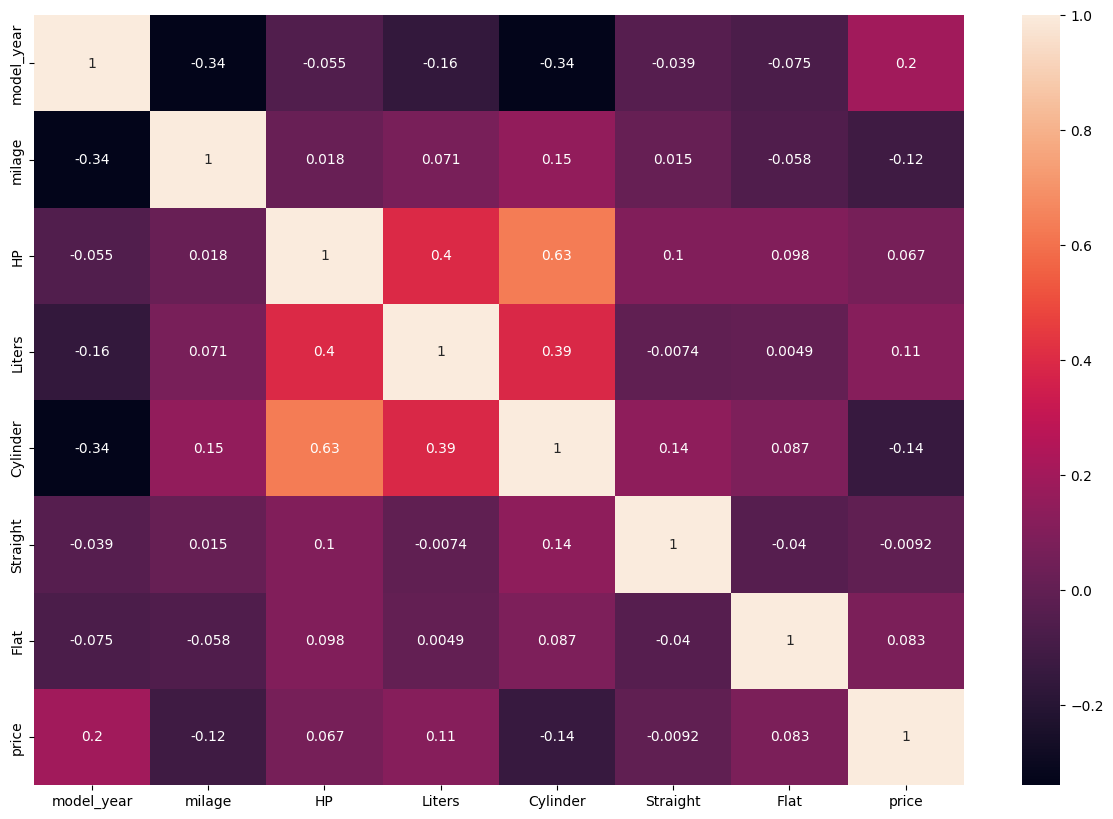

In [ ]:
numerical_columns = ['model_year','milage','HP','Liters','Cylinder','Straight','Flat','price']

plt.figure(figsize=(15, 10))
sns.heatmap(df[numerical_columns].corr(), annot=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   brand                 4009 non-null   object 
 1   model                 4009 non-null   object 
 2   model_year            4009 non-null   int64  
 3   milage                4009 non-null   float64
 4   fuel_type             3839 non-null   object 
 5   engine                4009 non-null   object 
 6   transmission          4009 non-null   object 
 7   ext_col               4009 non-null   object 
 8   int_col               4009 non-null   object 
 9   accident              3896 non-null   object 
 10  clean_title           3413 non-null   object 
 11  price                 4009 non-null   float64
 12  fuel_type_codificado  4009 non-null   float64
 13  engine_tamanho_texto  4009 non-null   int64  
 14  HP                    4009 non-null   float64
 15  Liters               

**TRAIN**

In [ ]:
categorical_columns = ['milage', 'fuel_type_codificado', 'HP', 'Liters', 'model', 'brand', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']

In [ ]:
df2 = df.copy()

In [ ]:
label_encoder = LabelEncoder()
for col in categorical_columns:
  df2[col] = label_encoder.fit_transform(df2[col])

In [ ]:
x_train,x_test,y_train_,y_test = train_test_split(df2, df2['price'], test_size=0.2, random_state=42)

In [ ]:
x_train = x_train.drop(['price'], axis=1)
x_test = x_test.drop(['price'], axis=1)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train_)
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print("AC: ", accuracy*100)

In [ ]:
model2 = LogisticRegression()
model2.fit(X_train, y_train_)
accuracy2 = model2.score(X_test, y_test)
print("AC: ", accuracy2)

AC:  0.008728179551122194


**KFOLD**

In [ ]:
from sklearn.model_selection import KFold
# Criando o objeto KFold com 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # shuffle=True embaralha os dados antes de dividir

# Iterando sobre os folds e treinando/avaliando o modelo
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]

    y_train_fold, y_test_fold = y_train_.iloc[train_index], y_train_.iloc[test_index]

    # Treinando o modelo no conjunto de treinamento do fold
    model.fit(X_train_fold, y_train_fold)

    # Avaliando o modelo no conjunto de teste do fold
    y_pred_fold = model.predict(X_test_fold)
    accuracy_fold = model.score(X_test_fold, y_test_fold)
    print("Acurácia no fold:", accuracy_fold)

Acurácia no fold: 0.7752339261171425
Acurácia no fold: 0.7524094478363532
Acurácia no fold: 0.7572147970144819
Acurácia no fold: 0.7467817335124194
Acurácia no fold: 0.7731238390964312


In [ ]:
    accuracy = model.score(X_test, y_test)
    print("Acurácia no fold:", accuracy*100)

Acurácia no fold: 75.9663860504078
